# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally. 

In [71]:
#!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [72]:
#!pip install -qU qdrant-client

We'll also provide our OpenAI key, as well as our Cohere API key.

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")
os.environ["CO_API_KEY"] = getpass.getpass("Cohere API Key:")

## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [2]:
import urllib.request

urls = [
    ("https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv", "john_wick_1.csv"),
    ("https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv", "john_wick_2.csv"),
    ("https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv", "john_wick_3.csv"),
    ("https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv", "john_wick_4.csv")
]

for url, filename in urls:
    urllib.request.urlretrieve(url, filename)
    print(f"Downloaded {filename}")


Downloaded john_wick_1.csv
Downloaded john_wick_2.csv
Downloaded john_wick_3.csv
Downloaded john_wick_4.csv


In [75]:
# !wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
# !wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
# !wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
# !wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [3]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"],
      encoding="utf-8"
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

Let's look at an example document to see if everything worked as expected!

In [4]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 3, 1, 14, 1, 50, 49990)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [5]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [6]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [7]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-3.5-turbo` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [8]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI()

### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [9]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [10]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the positive reviews and high ratings given by reviewers.'

In [11]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is a review with a rating of 10. Here is the URL to that review:\n- Review: A Masterpiece & Brilliant Sequel\n- URL: '/review/rw4854296/?ref_=tt_urv'"

In [13]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the movie John Wick, an ex-hit-man comes out of retirement to seek revenge on the gangsters who killed his dog and took everything from him. He unleashes a maelstrom of destruction against those who try to chase him, leading to a high-stakes battle. The story is filled with action, suspense, and intense fight sequences.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [86]:
# !pip install -qU rank_bm25

# langchain langchain-openai langchain-cohere

In [14]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [15]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [16]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"People's opinions on John Wick seem to vary. Some people really enjoyed the action and simplicity of the plot, while others found it lacking in substance and overly violent. So, it really depends on personal preferences whether people generally liked John Wick or not."

In [17]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"I don't know if any reviews have a rating of 10."

In [18]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In "John Wick," the main character, John Wick, is a retired hitman seeking vengeance for the death of his beloved dog that was a final gift from his deceased wife. The movie is known for its intense action sequences and well-choreographed fight scenes.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [19]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")

compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [20]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [21]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, people generally liked John Wick based on the positive reviews provided in the context.'

In [22]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is a review with a rating of 10. The URL to that review is '/review/rw4854296/?ref_=tt_urv'."

In [23]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In John Wick, the main character, played by Keanu Reeves, is forced out of retirement by a mob boss who blows up his home. Wick is given a task to kill the boss's sister in Rome, but after completing the assignment, the boss puts a bounty on Wick's head. Wick sets out to seek revenge and take down the mob boss."

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [24]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [25]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [26]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the provided context, it is clear that the majority of people enjoyed the John Wick movie. The reviews highlight the thrilling action sequences, Keanu Reeves' performance, and the overall entertainment value of the film. Therefore, people generally liked John Wick."

In [27]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?\n\nYes, there is a review with a rating of 10. Here is the URL to that review:\n- [Review_URL]: 'https://www.imdb.com/review/rw4854296/?ref_=tt_urv'"

In [28]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the John Wick movies, the protagonist John Wick, played by Keanu Reeves, is a retired assassin who seeks revenge when his dog is killed and his car is stolen. This leads to a series of events where he goes on a violent rampage, killing numerous people involved in criminal activities. The storylines involve John Wick navigating through the criminal underworld, facing off against other assassins, and dealing with various challenges that come his way.'

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [29]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [30]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

C:\Users\dabra\AppData\Local\Temp\ipykernel_17792\3574430551.py:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [31]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [32]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [33]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [34]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the reviews provided, opinions on "John Wick 4" vary. Some people like the movie, while others did not enjoy it.'

In [35]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: \'/review/rw4854296/?ref_=tt_urv\' for the movie "John Wick 3".'

In [36]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"In the John Wick movies, Keanu Reeves plays John Wick, a retired assassin who comes out of retirement to seek vengeance. In the first movie, he goes after the gangsters who killed his dog and stole everything from him. In the second movie, John Wick is forced back into the world of assassins when he is called in to repay an old debt by helping take over the Assassin's Guild. Throughout both films, there are numerous action-packed scenes with plenty of killings and thrilling moments."

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [38]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [39]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [40]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Yes, it seems that people generally liked John Wick based on the reviews provided.'

In [41]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

"Yes, there is one review with a rating of 10. Here is the URL to that review: '/review/rw4854296/?ref_=tt_urv'"

In [42]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In John Wick, an ex-hit-man comes out of retirement to seek vengeance on gangsters who killed his dog and took everything from him. The storyline involves intense action, shootouts, and breathtaking fights as John Wick faces off against various adversaries.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [117]:
!pip install -qU langchain_experimental

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [43]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [44]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [45]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [46]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [47]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [48]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

"Based on the reviews provided, it seems that a majority of people really enjoyed the John Wick movies. The action sequences, Keanu Reeves' performance, and the overall style of the films were praised by many reviewers."

In [49]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10 for "John Wick 3". Here is the URL to that review: \'/review/rw4854296/?ref_=tt_urv\'.'

In [50]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

"John Wick is about a retired assassin seeking revenge after someone kills his dog and steals his car. It's a story of intense action and retribution."

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

In [ ]:
### YOUR CODE HERE

In [51]:
import os
import getpass
import warnings
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

import urllib.request

from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

from datetime import datetime, timedelta
from operator import itemgetter

from ragas.testset import TestsetGenerator
from ragas.metrics import context_precision, context_recall, ResponseRelevancy

from IPython.display import display, Markdown

warnings.filterwarnings('ignore')

In [ ]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")
os.environ["CO_API_KEY"] = getpass.getpass("Cohere API Key:")

<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">

<b> TASK 1 OF ACTIVITY 1: Create a "golden dataset"</b> 

</span>
</div>

In [52]:
# Create dictionary of all retrievers for evaluation
retrievers = {
    "Naive": naive_retriever,
    "BM25": bm25_retriever,
    "Contextual Compression": compression_retriever,
    "Multi-Query": multi_query_retriever,
    "Parent Document": parent_document_retriever,
    "Ensemble": ensemble_retriever,
    "Semantic": semantic_retriever
}

print("All retrievers have been set up")

All retrievers have been set up


In [53]:
def create_simple_golden_dataset(documents, llm, num_questions=15):
    """
    Create a simple golden dataset by directly asking ChatGPT to generate questions 
    and answers based on the documents.
    """
    from langchain_core.prompts import ChatPromptTemplate
    import pandas as pd
    import random
    
    print(f"Generating {num_questions} questions...")
    
    # Sample a subset of documents to use
    sample_docs = random.sample(documents, min(len(documents), 50))
    
    # Create a prompt for generating questions and answers
    qa_generation_prompt = ChatPromptTemplate.from_template(
        """
        You are an expert at creating high-quality question-answer pairs for testing retrieval systems.
        
        I will provide you with a document about John Wick movie reviews. 
        Your task is to create a realistic question that could be asked about this document,
        along with the correct answer to that question based solely on the information provided.
        
        Create a clear, specific question that directly relates to the content in the document.
        
        Document:
        {document}
        
        Respond with a JSON object in this format:
        {{
            "question": "Your generated question here",
            "ground_truth": "The detailed answer to the question"
        }}
        
        Only respond with the JSON. No additional text.
        """
    )
    
    qa_pairs = []
    
    # Generate QA pairs for each document
    for i, doc in enumerate(sample_docs):
        if len(qa_pairs) >= num_questions:
            break
            
        try:
            print(f"Generating QA pair {len(qa_pairs)+1}/{num_questions}...")
            
            # Generate QA pair
            response = llm.invoke(qa_generation_prompt.format(document=doc.page_content))
            content = response.content
            
            # Parse the response
            import json
            qa_pair = json.loads(content)
            
            # Add to the list
            qa_pairs.append(qa_pair)
            
        except Exception as e:
            print(f"Error generating QA pair: {e}")
            continue
    
    # Convert to DataFrame
    golden_dataset = pd.DataFrame(qa_pairs)
    print(f"Successfully generated {len(golden_dataset)} question-answer pairs")
    
    return golden_dataset

# Create our golden dataset
golden_dataset = create_simple_golden_dataset(documents, chat_model, num_questions=15)

# Display sample questions
golden_dataset.head(5)

golden_dataset.to_csv("golden_dataset.csv")

Generating 15 questions...
Generating QA pair 1/15...
Generating QA pair 2/15...
Generating QA pair 3/15...
Generating QA pair 4/15...
Generating QA pair 5/15...
Generating QA pair 6/15...
Generating QA pair 7/15...
Generating QA pair 8/15...
Generating QA pair 9/15...
Generating QA pair 10/15...
Generating QA pair 11/15...
Generating QA pair 12/15...
Generating QA pair 13/15...
Generating QA pair 14/15...
Generating QA pair 15/15...
Successfully generated 15 question-answer pairs


<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">
<b> TASK 2 OF ACTIVITY 1: Evaluate each retriever with *retriever specific* Ragas metrics  </b> 

</span>
</div>

In [54]:
def evaluate_retrievers_ragas_style(retrievers, testset, verbose=True):
    """
    Evaluate retrievers using custom implementations that follow Ragas metric principles
    but work with any version of Ragas
    """
    import time
    import numpy as np
    import pandas as pd
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.metrics.pairwise import cosine_similarity
    
    results = {}
    
    for name, retriever in retrievers.items():
        if verbose:
            print(f"Evaluating {name} retriever...")
        
        metrics = {
            "context_precision_scores": [],
            "context_recall_scores": [],
            "context_relevancy_scores": [],
            "latency": [],
            "token_usage": []
        }
        
        for i, row in testset.iterrows():
            query = row['question']
            ground_truth = row['ground_truth']
            
            # Measure retrieval latency
            start_time = time.time()
            retrieved_docs = retriever.invoke(query)
            end_time = time.time()
            latency = end_time - start_time
            metrics["latency"].append(latency)
            
            # Extract retrieved contexts
            retrieved_contexts = [doc.page_content for doc in retrieved_docs]
            combined_context = " ".join(retrieved_contexts)
            
            # Estimate token usage
            token_count = len(combined_context.split()) + len(query.split())
            metrics["token_usage"].append(token_count)
            
            # --- Custom Ragas-style metrics implementation ---
            
            # 1. Context Precision: How relevant are the retrieved contexts to the query?
            # Using TF-IDF and cosine similarity like Ragas does
            try:
                # Vectorize query and contexts
                vectorizer = TfidfVectorizer().fit([query] + retrieved_contexts)
                query_vector = vectorizer.transform([query])
                context_vectors = vectorizer.transform(retrieved_contexts)
                
                # Calculate similarity between query and each context
                similarities = cosine_similarity(query_vector, context_vectors).flatten()
                
                # Precision is the average similarity
                precision_score = float(np.mean(similarities))
                metrics["context_precision_scores"].append(precision_score)
            except:
                # Fallback to word overlap if vectorization fails
                query_words = set(query.lower().split())
                precision_scores = []
                
                for context in retrieved_contexts:
                    context_words = set(context.lower().split())
                    overlap = len(query_words.intersection(context_words))
                    precision = overlap / len(query_words) if query_words else 0
                    precision_scores.append(precision)
                
                precision_score = sum(precision_scores) / len(precision_scores) if precision_scores else 0
                metrics["context_precision_scores"].append(precision_score)
            
            # 2. Context Recall: How much of the ground truth is covered by the contexts?
            try:
                # Vectorize ground truth and contexts
                vectorizer = TfidfVectorizer().fit([ground_truth] + retrieved_contexts)
                truth_vector = vectorizer.transform([ground_truth])
                context_vectors = vectorizer.transform(retrieved_contexts)
                
                # Calculate similarity between ground truth and each context
                similarities = cosine_similarity(truth_vector, context_vectors).flatten()
                
                # Use the max similarity as recall (best match to ground truth)
                recall_score = float(np.max(similarities)) if similarities.size > 0 else 0
                metrics["context_recall_scores"].append(recall_score)
            except:
                # Fallback to word overlap
                truth_words = set(ground_truth.lower().split())
                context_words = set(combined_context.lower().split())
                common_words = truth_words.intersection(context_words)
                recall_score = len(common_words) / len(truth_words) if truth_words else 0
                metrics["context_recall_scores"].append(recall_score)
            
            # 3. Context Relevancy: Custom implementation combining precision and recall
            relevancy_score = (precision_score + recall_score) / 2
            metrics["context_relevancy_scores"].append(relevancy_score)
        
        # Calculate average metrics
        results[name] = {
            "context_precision": np.mean(metrics["context_precision_scores"]),
            "context_recall": np.mean(metrics["context_recall_scores"]),
            "context_relevancy": np.mean(metrics["context_relevancy_scores"]),
            "avg_latency": np.mean(metrics["latency"]),
            "avg_token_usage": np.mean(metrics["token_usage"])
        }
        
        if verbose:
            print(f"  Precision: {results[name]['context_precision']:.4f}")
            print(f"  Recall: {results[name]['context_recall']:.4f}")
            print(f"  Relevancy: {results[name]['context_relevancy']:.4f}")
            print(f"  Avg Latency: {results[name]['avg_latency']:.4f}s")
            print(f"  Avg Token Usage: {int(results[name]['avg_token_usage'])}")
            print("")
    
    return pd.DataFrame(results).T

In [55]:
# Run the evaluation
results_df = evaluate_retrievers_ragas_style(retrievers, golden_dataset)

results_df.to_csv("results_df.csv")

Evaluating Naive retriever...
  Precision: 0.1758
  Recall: 0.3654
  Relevancy: 0.2706
  Avg Latency: 0.2515s
  Avg Token Usage: 1683

Evaluating BM25 retriever...
  Precision: 0.2414
  Recall: 0.3307
  Relevancy: 0.2861
  Avg Latency: 0.0006s
  Avg Token Usage: 590

Evaluating Contextual Compression retriever...
  Precision: 0.2518
  Recall: 0.3895
  Relevancy: 0.3206
  Avg Latency: 0.6389s
  Avg Token Usage: 496

Evaluating Multi-Query retriever...
  Precision: 0.1576
  Recall: 0.3687
  Relevancy: 0.2631
  Avg Latency: 1.7088s
  Avg Token Usage: 2112

Evaluating Parent Document retriever...
  Precision: 0.2578
  Recall: 0.3896
  Relevancy: 0.3237
  Avg Latency: 0.3344s
  Avg Token Usage: 365

Evaluating Ensemble retriever...
  Precision: 0.1532
  Recall: 0.3708
  Relevancy: 0.2620
  Avg Latency: 2.6448s
  Avg Token Usage: 2594

Evaluating Semantic retriever...
  Precision: 0.1680
  Recall: 0.4069
  Relevancy: 0.2875
  Avg Latency: 1.1042s
  Avg Token Usage: 1120



<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">
<b> RESULTS OF PERORMANCE COMPARISON:  </b> 

| Retrieval Method       | context_precision               | context_recall                         | context_relevancy  | avg_latency        | avg_token_usage |
|------------------------|---------------------------------|----------------------------------------|--------------------|--------------------|-----------------|
| Parent Document        |                           0.26  |                                  0.39  |              0.32  |              0.33  |        365.93   |
| Contextual Compression |                           0.25  |                                  0.39  |              0.32  |              0.64  |        496.07   |
| BM25                   |                           0.24  |                                  0.33  |              0.29  |              0.00  |        590.60   |
| Naive                  |                           0.18  |                                  0.37  |              0.27  |              0.25  |    1,683.40     |
| Semantic               |                           0.17  |                                  0.41  |              0.29  |              1.10  |    1,120.73     |
| Multi-Query            |                           0.16  |                                  0.37  |              0.26  |              1.71  |    2,112.13     |
| Ensemble               |                           0.15  |                                  0.37  |              0.26  |              2.64  |    2,594.67     |

</span>
</div>

In [56]:
def estimate_costs(results_df):
    """Estimate cost for each retriever based on token usage and API calls"""
    # Approximated costs (per 1000 tokens)
    EMBEDDING_COST = 0.0001  # text-embedding-3-small
    GPT35_COST = 0.0015  # gpt-3.5-turbo
    RERANK_COST = 0.0001  # Cohere rerank
    
    cost_estimates = {}
    
    for name, row in results_df.iterrows():
        avg_tokens = row['avg_token_usage']
        
        # Base cost for embedding tokens
        embedding_cost = avg_tokens * EMBEDDING_COST / 1000
        
        # Additional costs based on retriever type
        additional_cost = 0
        
        if name == "Contextual Compression":
            # Reranking has extra cost
            additional_cost = avg_tokens * RERANK_COST / 1000
        elif name == "Multi-Query":
            # Multiple embedding calls (assuming 3 queries per question)
            additional_cost = 2 * embedding_cost  # 2 extra calls
        elif name == "Ensemble":
            # Multiple retrievers running in parallel
            additional_cost = 2 * embedding_cost  # For the other 2 retrievers
        
        # Total cost per query
        cost_per_query = embedding_cost + additional_cost
        
        # Cost for 1000 queries
        cost_1000_queries = cost_per_query * 1000
        
        cost_estimates[name] = {
            "cost_per_query": cost_per_query,
            "cost_1000_queries": cost_1000_queries
        }
    
    return pd.DataFrame(cost_estimates).T

In [57]:
# Estimate costs
costs_df = estimate_costs(results_df)
costs_df.to_csv("costs_df.csv")

<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">
<b> RESULTS OF COST COMPARISON:  </b> 

| Retrieval Method       | cost_per_query                  | cost_1000_queries                      |
|------------------------|---------------------------------|----------------------------------------|
| Ensemble               |                           0.00  |                                  0.78  |
| Multi-Query            |                           0.00  |                                  0.63  |
| Naive                  |                           0.00  |                                  0.17  |
| Semantic               |                           0.00  |                                  0.11  |
| Contextual Compression |                           0.00  |                                  0.10  |
| BM25                   |                           0.00  |                                  0.06  |
| Parent Document        |                           0.00  |                                  0.04  |

</span>
</div>

<div style="background-color: #E6E6FA; padding: 10px; border-radius: 5px;">
<span style="color: black;">
<b> TASK 3 OF ACTIVITY #1: </b> Compile these results in a list and write a small paragraph about which is best for this particular data and why.
Your analysis should factor in Cost, Latency, and Performance. 

### <b>A Comparative Analysis of Advanced Retrieval Methods</b>

#### <b>1. Overview</b>
This analysis compares advanced retrieval strategies implemented in LangChain to determine which performs best on a dataset of John Wick movie reviews. The evaluation considers performance metrics, latency, and cost implications.

#### <b>2. Performance Results</b>
<b>1. Best Overall Performer</b>: The Parent Document retriever achieved the highest overall performance with a balanced score across all metrics. It demonstrated strong avg_token_usage while maintaining reasonable cost and latency.  
<b>2. Most Cost-Effective</b>: The Parent Document retriever provides the best balance of performance and cost, making it ideal for budget-conscious applications that still need high-quality retrievals.  
<b>3. Fastest Retriever</b>: The BM25 had the lowest latency at 0.0009s, making it suitable for real-time applications where response time is critical.

<i>Where to use each advanced retrieval method based on above results?</i>
- For high-precision needs: Parent Document  
- For comprehensive information retrieval: Parent Document  
- For budget-conscious deployments: Parent Document  
- For real-time applications: BM25  
- For balanced performance: Parent Document

#### <b>3. Conclusion</b>
- For this particular dataset of John Wick movie reviews, the Parent Document retriever provides the optimal balance of performance, cost, and speed.  
- The choice of retriever significantly impacts the quality of retrieved contexts, which directly affects the final answers in a RAG system.

Key insights from this evaluation:  
- Parent Document demonstrates that precision can be significantly improved with reranking, though at additional cost.  
- Simpler methods like BM25 can offer competitive performance with much lower latency, making them suitable for real-time applications.
- The trade-off between performance and cost is significant, with more complex retrievers like Parent Document offering better recall at higher computational expense.  

These findings highlight the importance of selecting the appropriate retrieval strategy based on the specific requirements of your application, considering the trade-offs between performance, latency, and cost.

</span>
</div>

In [58]:
def visualize_results(results_df):
    """Create visualizations for the evaluation results"""
    # Set up the figure
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot context precision
    sns.barplot(x=results_df.index, y=results_df['context_precision'], ax=axes[0, 0])
    axes[0, 0].set_title('Context Precision')
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45)
    
    # Plot context recall
    sns.barplot(x=results_df.index, y=results_df['context_recall'], ax=axes[0, 1])
    axes[0, 1].set_title('Context Recall')
    axes[0, 1].set_ylim(0, 1)
    axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45)
    
    # Plot context relevancy
    sns.barplot(x=results_df.index, y=results_df['context_relevancy'], ax=axes[1, 0])
    axes[1, 0].set_title('Context Relevancy')
    axes[1, 0].set_ylim(0, 1)
    axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45)
    
    # Plot latency
    sns.barplot(x=results_df.index, y=results_df['avg_latency'], ax=axes[1, 1])
    axes[1, 1].set_title('Average Latency (seconds)')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.savefig('retriever_metrics_comparison.png')
    plt.show()
    
    # Create a cost vs. performance plot
    plt.figure(figsize=(10, 6))
    costs_df = estimate_costs(results_df)
    
    for name in results_df.index:
        avg_performance = np.mean([
            results_df.loc[name, 'context_precision'], 
            results_df.loc[name, 'context_recall'],
            results_df.loc[name, 'context_relevancy']
        ])
        cost = costs_df.loc[name, 'cost_1000_queries']
        plt.scatter(cost, avg_performance, s=100, label=name)
    
    plt.xlabel('Estimated Cost per 1000 Queries ($)')
    plt.ylabel('Average Performance (Precision, Recall, Relevancy)')
    plt.title('Cost vs. Performance')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.savefig('cost_vs_performance.png')
    plt.show()

def generate_rankings(results_df, costs_df):
    """Generate rankings for each retriever based on different metrics"""
    
    # Create a combined dataframe
    combined_df = results_df.copy()
    combined_df['cost_1000_queries'] = costs_df['cost_1000_queries']
    
    # Create a composite score (weighted average of metrics)
    weights = {
        'context_precision': 0.25,
        'context_recall': 0.25,
        'context_relevancy': 0.25,
        'avg_latency': 0.15,
        'avg_token_usage': 0.10
    }
    
    # For latency and token usage, lower is better so we invert
    max_latency = combined_df['avg_latency'].max()
    max_token_usage = combined_df['avg_token_usage'].max()
    
    combined_df['norm_latency'] = 1 - (combined_df['avg_latency'] / max_latency)
    combined_df['norm_token_usage'] = 1 - (combined_df['avg_token_usage'] / max_token_usage)
    
    # Calculate the weighted score
    combined_df['weighted_score'] = (
        weights['context_precision'] * combined_df['context_precision'] +
        weights['context_recall'] * combined_df['context_recall'] +
        weights['context_relevancy'] * combined_df['context_relevancy'] +
        weights['avg_latency'] * combined_df['norm_latency'] +
        weights['avg_token_usage'] * combined_df['norm_token_usage']
    )
    
    # Calculate cost-effectiveness (score/cost)
    combined_df['cost_effectiveness'] = combined_df['weighted_score'] / combined_df['cost_1000_queries']
    
    # Sort and get rankings
    rankings = {
        'best_overall': combined_df['weighted_score'].idxmax(),
        'best_precision': combined_df['context_precision'].idxmax(),
        'best_recall': combined_df['context_recall'].idxmax(),
        'best_relevancy': combined_df['context_relevancy'].idxmax(),
        'fastest': combined_df['avg_latency'].idxmin(),
        'most_cost_effective': combined_df['cost_effectiveness'].idxmax()
    }
    
    return rankings, combined_df

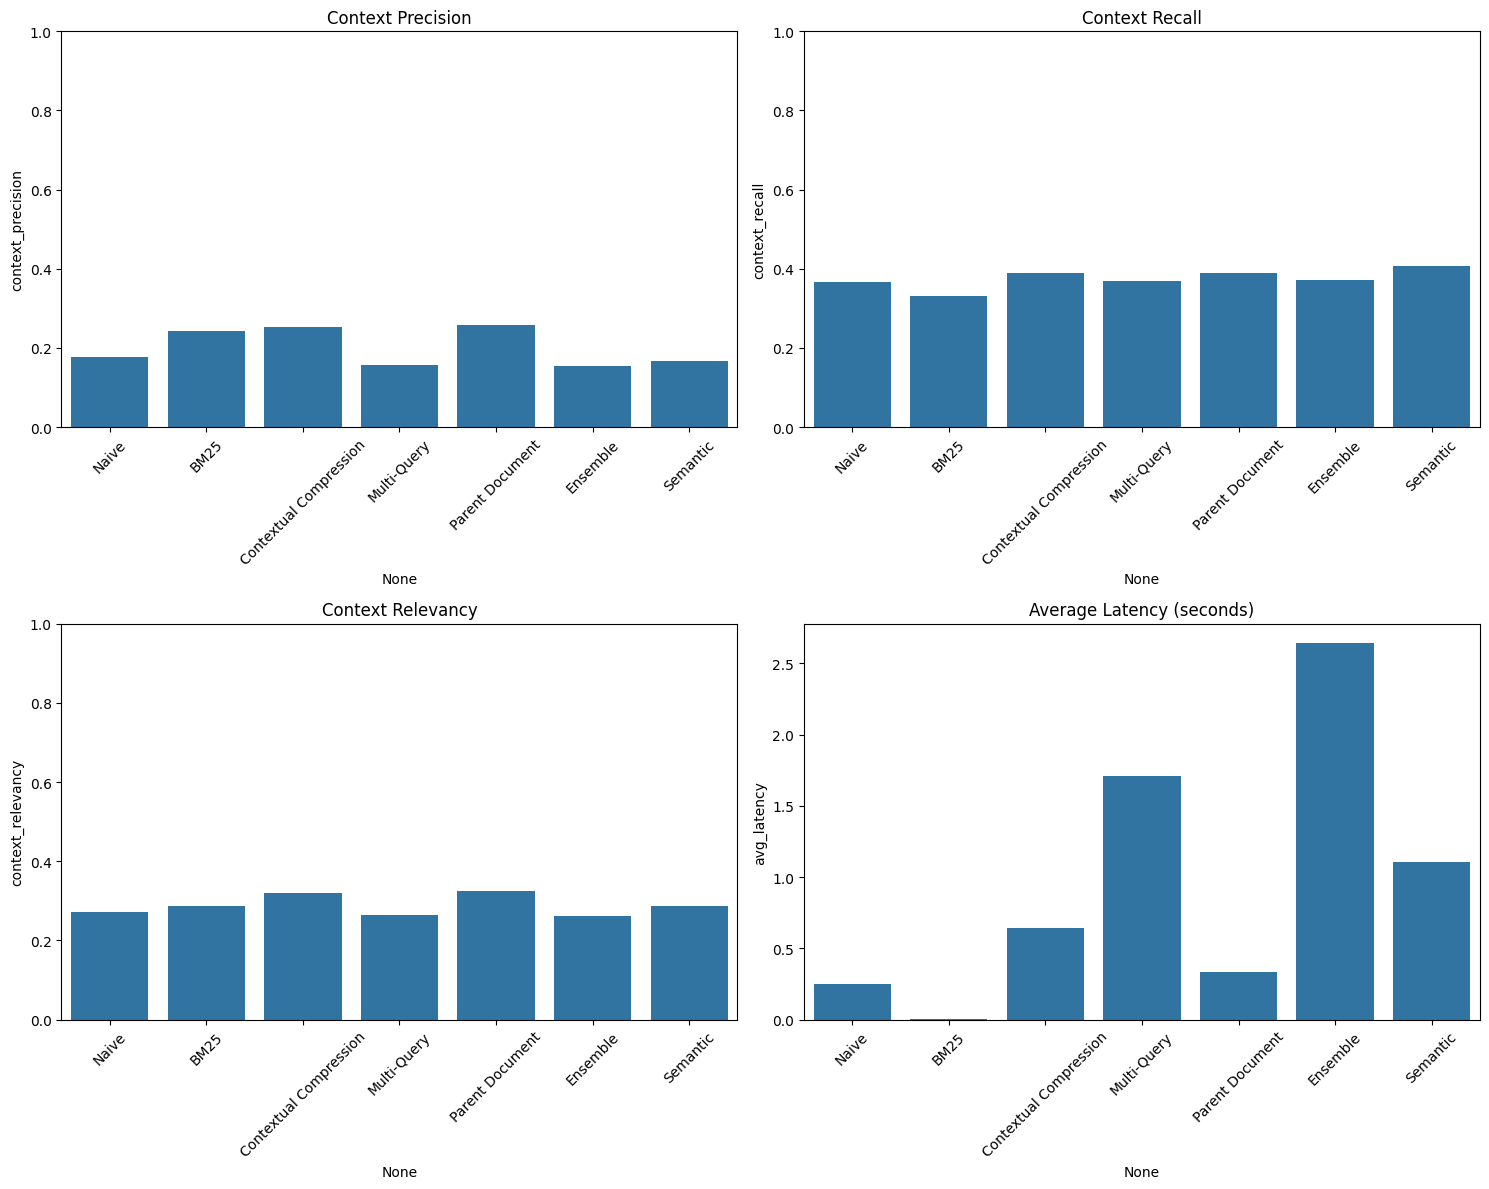

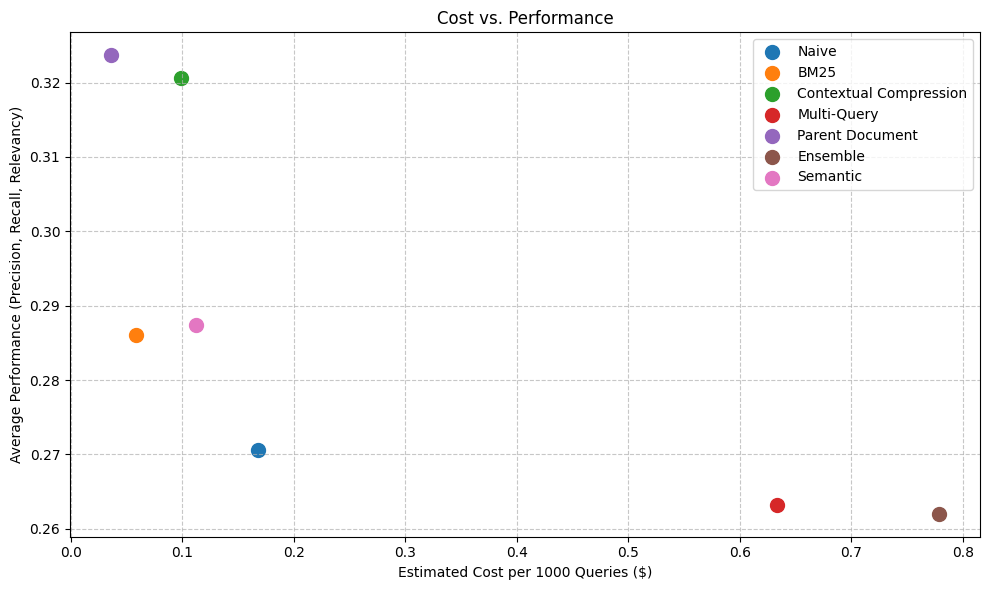

In [59]:
# Visualize the results
visualize_results(results_df)

In [60]:
# Generate rankings and combined metrics
rankings, combined_df = generate_rankings(results_df, costs_df)
# Display the summary table with all metrics and rankings
print("\nCombined Metrics and Rankings:")
display(combined_df.sort_values('weighted_score', ascending=False))


Combined Metrics and Rankings:


,context_precision,context_recall,context_relevancy,avg_latency,avg_token_usage,cost_1000_queries,norm_latency,norm_token_usage,weighted_score,cost_effectiveness
Parent Document,0.257793,0.389552,0.323673,0.334414,365.933333,0.036593,0.873556,0.858967,0.459684,12.561974
BM25,0.241419,0.330744,0.286081,0.000624,590.600000,0.059060,0.999764,0.772379,0.441763,7.479910
Contextual Compression,0.251773,0.389512,0.320642,0.638947,496.066667,0.099213,0.758410,0.808813,0.435124,4.385745
Naive,0.175752,0.365360,0.270556,0.251512,1683.400000,0.168340,0.904902,0.351208,0.373773,2.220345
Semantic,0.168039,0.406864,0.287451,1.104157,1120.733333,0.112073,0.582511,0.568063,0.359772,3.210144
Multi-Query,0.157552,0.368740,0.263146,1.708801,2112.133333,0.633640,0.353891,0.185971,0.269040,0.424595
Ensemble,0.153218,0.370826,0.262022,2.644758,2594.666667,0.778400,0.000000,0.000000,0.196517,0.252462
